# MLBの投手と給料の関連性(9-Oct-2017)

以下の順番で確認。

1. データセット準備
2. データチェック
3. 相関係数から関連性を確認
4. 結論

# データセット準備

- Pitching.csvとSalaries.csvの結合にはmerge(inner)を利用。
- meger(outer)の方が母数が多くなるが、正確に情報を判断するため、NaNが少なく、多くのデータが揃うmerge(inner)でデータセットを準備。

データは[ここ](http://www.seanlahman.com/baseball-archive/statistics/)からダウンロード。

In [863]:
import pandas as pd
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [478]:
pitching_df = pd.read_csv("testdata/core/Pitching.csv")
salary_df = pd.read_csv("testdata/core/Salaries.csv")

In [479]:
#df = pd.merge(pitching_df,salary_df,on=['yearID', 'teamID', 'playerID'])
#df = pd.merge(pitching_df,salary_df,on=['yearID', 'teamID', 'lgID', 'playerID'], how='outer')
#df = pd.merge(pitching_df,salary_df,on=['yearID', 'teamID', 'playerID'], how='outer')
df = pd.merge(pitching_df,salary_df,on=['yearID', 'teamID', 'lgID', 'playerID'])

In [480]:
pitching_df[['yearID','teamID','lgID','playerID']].isnull().sum()

yearID        0
teamID        0
lgID        131
playerID      0
dtype: int64

In [481]:
salary_df[['yearID','teamID','lgID','playerID']].isnull().sum()

yearID      0
teamID      0
lgID        0
playerID    0
dtype: int64

In [482]:
df.count()

playerID    11797
yearID      11797
stint       11797
teamID      11797
lgID        11797
W           11797
L           11797
G           11797
GS          11797
CG          11797
SHO         11797
SV          11797
IPouts      11797
H           11797
ER          11797
HR          11797
BB          11797
SO          11797
BAOpp       11336
ERA         11792
IBB         11797
WP          11797
HBP         11797
BK          11797
BFP         11797
GF          11797
R           11797
SH           6481
SF           6481
GIDP         6481
salary      11797
dtype: int64

In [483]:
df['salary'].isnull().sum()

0

In [484]:
#how='inner'
#salary      11797  =====>母数が多い方が良いが、正確に情報を判断するには、一時的にすべてのデータが揃うmerge(inner)を扱う。
#how='outer'
#salary      26431   
#how='inner' minus lgID
#salary      11799

In [485]:
df_sal_nonan = df.dropna(subset=["salary"]).reset_index(drop=True)
combine = [df_sal_nonan]

以下、ただの確認。

In [486]:
#df_sal_nonan.isnull().sum()
#df_sal_nonan

In [487]:
#df_sal_nonan.columns.all

# データのチェック

## 連続、離散変数の確認
連続変数（continuous variable）と離散変数（discrete variable）の確認。必要に応じて下処理。

やること
1. teamIDとlgIDのカテゴリカルデータ（定性的データ）を定量的データに変換
2. playerIDが重複しているか確認
3. その他予想

In [488]:
df_sal_nonan.iloc[:,:20].head()

playerID  yearID  stint teamID lgID   W   L   G  GS  CG  SHO  SV  IPouts  \
0  ackerji01    1985      1    TOR   AL   7   2  61   0   0    0  10     259   
1  agostju01    1985      1    CHA   AL   4   3  54   0   0    0   1     181   
2  alexado01    1985      1    TOR   AL  17  10  36  36   6    1   0     782   
3  allenne01    1985      1    SLN   NL   1   4  23   1   0    0   2      87   
4  anderla02    1985      1    PHI   NL   3   3  57   0   0    0   3     219   

     H   ER  HR  BB   SO  BAOpp   ERA  
0   86   31   7  43   42   0.26  3.23  
1   45   24   3  23   39   0.21  3.58  
2  268  100  28  67  142   0.26  3.45  
3   32   18   3  17   10   0.28  5.59  
4   78   35   5  26   50   0.27  4.32

In [489]:
df_sal_nonan.iloc[:,20:].head()

IBB   WP  HBP  BK     BFP    GF    R  SH  SF  GIDP  salary
0  1.0  2.0  3.0   0   370.0  26.0   35 NaN NaN   NaN  170000
1  1.0  0.0  3.0   0   246.0  21.0   27 NaN NaN   NaN  147500
2  0.0  9.0  6.0   0  1090.0   0.0  105 NaN NaN   NaN  875000
3  6.0  1.0  1.0   1   135.0  13.0   22 NaN NaN   NaN  750000
4  4.0  1.0  3.0   1   318.0  19.0   41 NaN NaN   NaN  250500

### #1 ダミー変数作成
#### *teamID*

In [490]:
team_list = list(df_sal_nonan.teamID.unique())

In [491]:
teamID_mapping_d = dict({})
for ti, team_name in enumerate(team_list):
    teamID_mapping_d[team_name] = ti
teamID_mapping_d

{'ANA': 28,
 'ARI': 29,
 'ATL': 5,
 'BAL': 12,
 'BOS': 13,
 'CAL': 19,
 'CHA': 1,
 'CHN': 15,
 'CIN': 14,
 'CLE': 11,
 'COL': 26,
 'DET': 9,
 'FLO': 27,
 'HOU': 20,
 'KCA': 7,
 'LAA': 33,
 'LAN': 22,
 'MIA': 34,
 'MIL': 31,
 'MIN': 17,
 'ML4': 16,
 'MON': 24,
 'NYA': 18,
 'NYN': 8,
 'OAK': 4,
 'PHI': 3,
 'PIT': 21,
 'SDN': 23,
 'SEA': 6,
 'SFN': 10,
 'SLN': 2,
 'TBA': 30,
 'TEX': 25,
 'TOR': 0,
 'WAS': 32}

In [492]:
for dataset in combine:
    dataset['teamID'] = dataset['teamID'].map(teamID_mapping_d)
    dataset['teamID'] = dataset['teamID'].fillna(99)

In [223]:
df_sal_nonan.tail(3)

playerID  yearID  stint  teamID  lgID  W  L   G  GS  CG    ...     \
11794  zieglbr01    2016      1      29     2  2  3  36   0   0    ...      
11795  zimmejo02    2016      1       9     1  9  7  19  18   0    ...      
11796   zychto01    2016      1       6     1  1  0  12   0   0    ...      

        WP  HBP  BK    BFP    GF   R   SH   SF  GIDP    salary  
11794  0.0  2.0   0  165.0  30.0  13  1.0  1.0  10.0   5500000  
11795  3.0  2.0   0  450.0   1.0  63  1.0  5.0   8.0  18000000  
11796  0.0  1.0   0   60.0   3.0   6  0.0  1.0   1.0    511000  

[3 rows x 31 columns]

#### *lgID*

In [209]:
df_sal_nonan.lgID.unique()

array(['AL', 'NL'], dtype=object)

In [210]:
df_sal_nonan.head(3)

playerID  yearID  stint teamID lgID   W   L   G  GS  CG   ...     WP  HBP  \
0  ackerji01    1985      1    TOR   AL   7   2  61   0   0   ...    2.0  3.0   
1  agostju01    1985      1    CHA   AL   4   3  54   0   0   ...    0.0  3.0   
2  alexado01    1985      1    TOR   AL  17  10  36  36   6   ...    9.0  6.0   

   BK     BFP    GF    R  SH  SF  GIDP  salary  
0   0   370.0  26.0   35 NaN NaN   NaN  170000  
1   0   246.0  21.0   27 NaN NaN   NaN  147500  
2   0  1090.0   0.0  105 NaN NaN   NaN  875000  

[3 rows x 31 columns]

In [541]:
lgID_mapping = {"AL": 1, "NL": 2}
for dataset in combine:
    dataset['lgID'] = dataset['lgID'].map(lgID_mapping)
    dataset['lgID'] = dataset['lgID'].fillna(0)

In [212]:
df_sal_nonan.head(3)

playerID  yearID  stint teamID  lgID   W   L   G  GS  CG   ...     WP  \
0  ackerji01    1985      1    TOR     1   7   2  61   0   0   ...    2.0   
1  agostju01    1985      1    CHA     1   4   3  54   0   0   ...    0.0   
2  alexado01    1985      1    TOR     1  17  10  36  36   6   ...    9.0   

   HBP  BK     BFP    GF    R  SH  SF  GIDP  salary  
0  3.0   0   370.0  26.0   35 NaN NaN   NaN  170000  
1  3.0   0   246.0  21.0   27 NaN NaN   NaN  147500  
2  6.0   0  1090.0   0.0  105 NaN NaN   NaN  875000  

[3 rows x 31 columns]

### #2 playerIDがユニークか確認
- playerIDはユニークではない。同じplayerIDが存在する。
- stintが増えると75%の選手のsalaryが減っている。

たとえユニークでなくてもsalaryが高い条件を確認する上でデータとしては有効であるとし、データは残して確認を進める。

Appendix. Aを参照。

### #3 予想
- Wが多いと、salary高い？ => 高くない。Appendix.Bを参照
- teamIDが人気球団だと(ex NYY)、salary高い？　=> 人気球団の定義がわからず、検証はやめる。



# 相関係数から関連性を確認
- corr()を使って相関係数が高いカラムを抽出する。　　

In [738]:
#df_sal_nonan.corr()

In [779]:
def pick_up_cor_value(dataframe_obj, corr_min_criteria):
    corr_matrix_df = dataframe_obj.corr()
    col_name_list = list(corr_matrix_df.columns)
    row_name_list = list(corr_matrix_df.index)
    output = [((row, col), corr_matrix_df.loc[row, col])
              for row in row_name_list
              for col in col_name_list
              if row != col
              if (corr_matrix_df.loc[row, col] > float(corr_min_criteria) or corr_matrix_df.loc[row, col] < -1 * float(corr_min_criteria) )
             ]
    return output

In [853]:
df_sal_array = pd.DataFrame(columns=["pair","cor"])
data = pick_up_cor_value(df_sal_nonan,0.05)

In [872]:
for d in data:
    pair, cor = d    
    if 'salary' in pair: 
#        df_tmp = pd.DataFrame([pair,cor],columns=["pair","cor"])
        df_tmp = pd.DataFrame({'pair': [pair],
                               'cor': [cor]},
                              columns=["pair","cor"])
        df_sal_array = df_sal_array.append(df_tmp)        

In [873]:
df_sal_array = df_sal_array[df_sal_array.duplicated('cor')]
df_sort = df_sal_array.sort_values(by='cor', ascending=False)

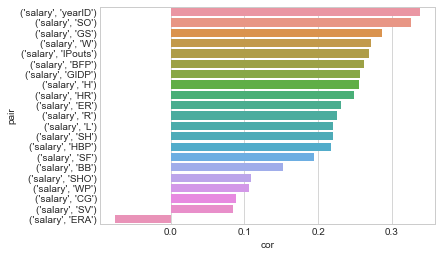

In [874]:
#sns.factorplot(x='r', y='Combination', data=df_sort, kind='bar')
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(6, 4))
ax = sns.barplot(x="cor", y="pair", data=df_sort)

# 結論
yearIDとSOが特にsalaryとの相関係数が高い。
- yearID
- SO (Strikeouts)
- GS (Games Started)

カテゴリカルデータであったlgID,teamIDの相関係数は低かった。*df_sal_nonan.corr()の結果より
- lgID: 0.006336
- teamID: 0.004177

# Appendix.

Appendix. A
* * * * * * * * * 

In [885]:
# is_uniqueか否かを確認
# df_sal_nonan.playerID.is_unique
df_sal_nonan.duplicated(['playerID']).any()

True

In [428]:
df_sal_nonan[df_sal_nonan.duplicated(['playerID'])].sort_values(by='playerID', ascending=False).tail(3)

playerID  yearID  stint  teamID  lgID  W  L   G  GS  CG   ...     WP  \
8357  aardsda01    2008      1      13     1  4  2  47   0   0   ...    3.0   
9929  aardsda01    2012      1      18     1  0  0   1   0   0   ...    0.0   
8753  aardsda01    2009      1       6     1  3  6  73   0   0   ...    2.0   

      HBP  BK    BFP    GF   R   SH   SF  GIDP  salary  
8357  5.0   0  228.0   7.0  32  3.0  2.0   4.0  403250  
9929  0.0   0    5.0   1.0   1  0.0  0.0   0.0  500000  
8753  0.0   0  296.0  53.0  23  2.0  1.0   2.0  419000  

[3 rows x 31 columns]

In [542]:
duplicated_name_list_uniq = list(set(duplicated_name_list))
len(duplicated_name_list_uniq)

1841

In [543]:
from collections import Counter

df_sal_nonan_dup_players = pd.DataFrame()

for dup_player_name in duplicated_name_list_uniq:
    tmp_df = df_sal_nonan[df_sal_nonan.playerID == dup_player_name]

    year_array = list(tmp_df.yearID)
    dup_player_year_list = [key for key,val in Counter(year_array).items() if val > 1]
    
    if dup_player_year_list:
        for year in dup_player_year_list:
            df_sal_nonan_dup_players = df_sal_nonan_dup_players.append(df_sal_nonan[\
                                                (df_sal_nonan["playerID"] == dup_player_name) &\
                                                (df_sal_nonan["yearID"] == year)])
    else:
        continue

df_sal_nonan_dup_players.head(3)

playerID  yearID  stint  teamID  lgID  W  L   G  GS  CG   ...     WP  \
4663  mormaal01    1998      1      11     1  0  1  31   0   0   ...    2.0   
4664  mormaal01    1998      2      10     2  0  1   9   0   0   ...    0.0   
3341  maddumi01    1995      1      21     2  1  0   8   0   0   ...    1.0   

      HBP  BK   BFP   GF   R  SH  SF  GIDP  salary  
4663  0.0   0  96.0  5.0  13 NaN NaN   NaN  220000  
4664  0.0   0  32.0  3.0   4 NaN NaN   NaN  220000  
3341  0.0   0  42.0  1.0   9 NaN NaN   NaN  200000  

[3 rows x 31 columns]

In [545]:
df_sal_nonan_dup_players = df_sal_nonan_dup_players.loc[:,['playerID','yearID','stint','salary']]
df_sal_nonan_dup_players.sort_values('playerID').head(3)

playerID  yearID  stint  salary
221   anderla02    1986      2   60000
220   anderla02    1986      1  240000
4439   bereja01    1998      2  170000

In [547]:
# 72 player have a varied stint (order of appearances within a season)
len(df_sal_nonan_dup_players)

72

In [587]:
df_grouped = df_sal_nonan_dup_players.groupby(['playerID','yearID'],as_index=False)['salary'].max()
df_grouped["max_salary_flg"] = np.array(1)

In [577]:
df_sal_nonan_w_flag = pd.merge(df_sal_nonan,df_grouped,on=['playerID', 'yearID', 'salary'],how='outer').iloc[:,[0,1,2,30,31]]
df_sal_nonan_w_flag[df_sal_nonan_w_flag["max_salary_flg"]==1].groupby("stint").count()

playerID  yearID  salary  max_salary_flg
stint                                          
1            34      34      34              34
2             8       8       8               8
3             2       2       2               2
4             1       1       1               1

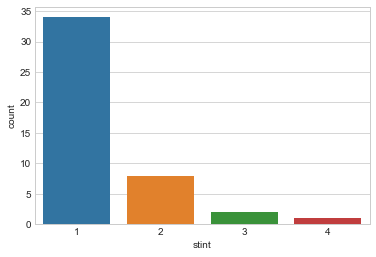

In [610]:
sns.countplot(x='stint',data=df_sal_nonan_w_flag[df_sal_nonan_w_flag["max_salary_flg"]==1])

In [620]:
df_sal_nonan_w_flag[df_sal_nonan_w_flag["max_salary_flg"]==1].describe(percentiles=[.75,.76])

yearID      stint        salary  max_salary_flg
count    45.000000  45.000000  4.500000e+01            45.0
mean   1996.355556   1.333333  6.515463e+05             1.0
std       3.338178   0.674200  6.289568e+05             0.0
min    1986.000000   1.000000  1.500000e+05             1.0
50%    1998.000000   1.000000  4.000000e+05             1.0
75%    1998.000000   1.000000  7.500000e+05             1.0
76%    1998.000000   1.440000  7.500000e+05             1.0
max    2000.000000   4.000000  2.466667e+06             1.0

* * * * * 

Appendix. B
* * * * 

__勝ち星とsalaryの関係__
- 勝ち星↑ならsalary↑の関係とは言えない。

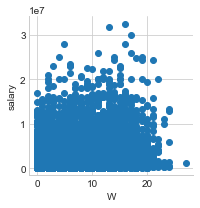

In [879]:
g = sns.FacetGrid(df,size=3)
g = g.map(plt.scatter, "W", "salary")

__年度別、チーム別のsalary__
- 直近の年度↑でsalaryが増加している。
- チームは多すぎて見分けがつかない。

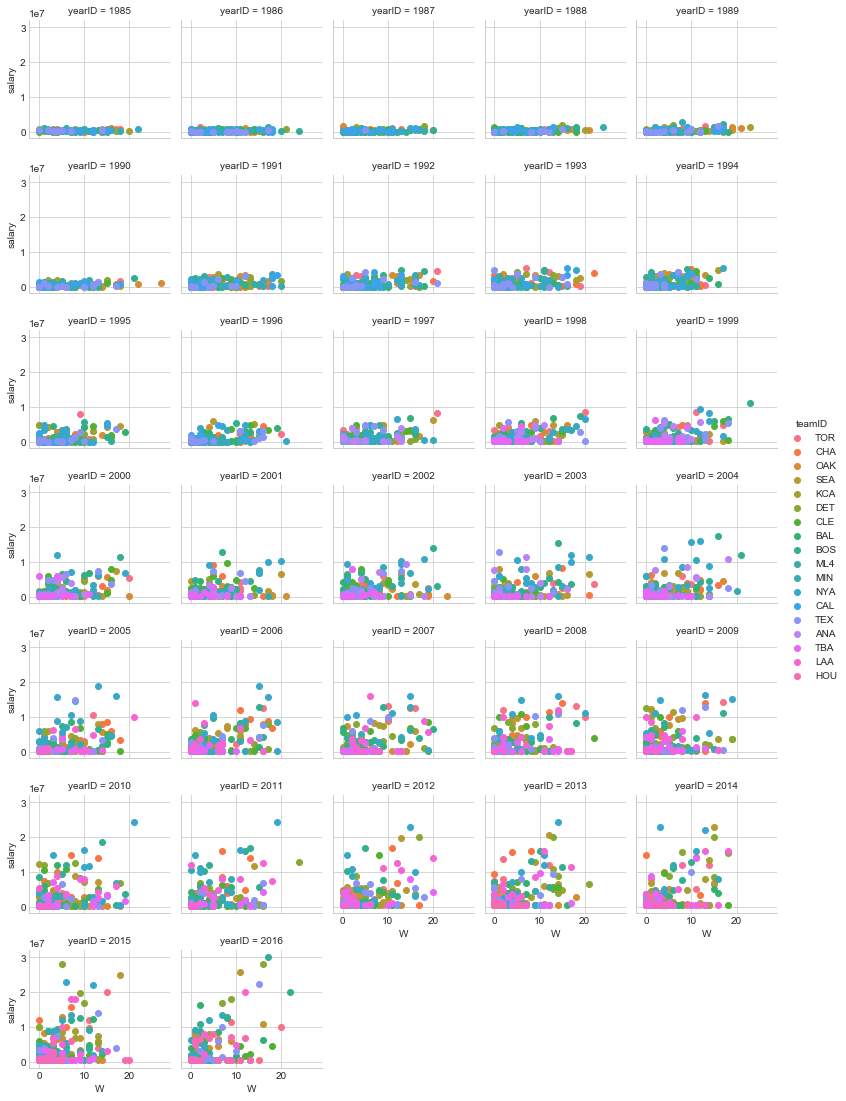

In [883]:
# American
g = sns.FacetGrid(df[df["lgID"].str.contains("AL")],col="yearID",hue="teamID",col_wrap=5,size=2.2)
g = g.map(plt.scatter, "W", "salary")
g.add_legend()

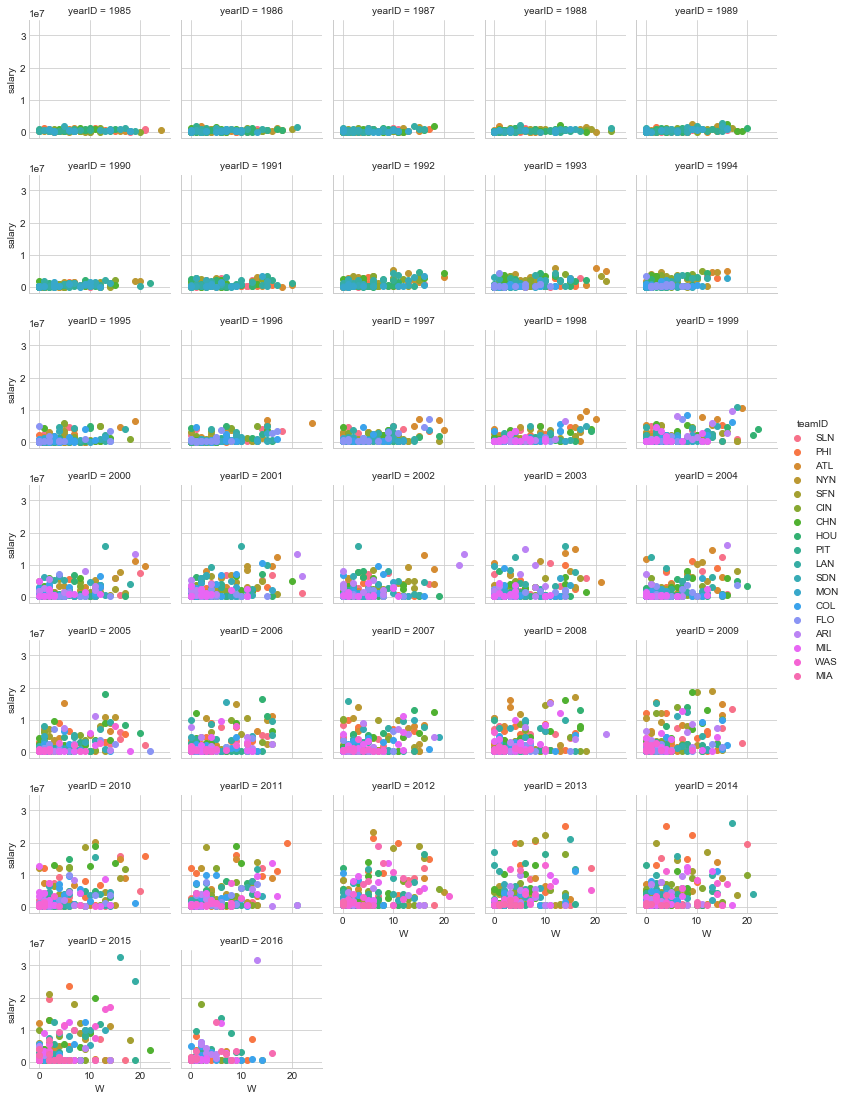

In [884]:
# National
g = sns.FacetGrid(df[df["lgID"].str.contains("NL")],col="yearID",hue="teamID",col_wrap=5,size=2.2)
g = g.map(plt.scatter, "W", "salary")
g.add_legend()

* * * * * 